In [1]:
import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
import copy
from matplotlib import pyplot as plt

from experiment_params import *
from cost_funcs import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

In [3]:
class ModelBase:
    # Hard coded attributes --> SHARED FOR THE ENTIRE CLASS
    num_updates = 19
    cphs_starting_update = 10
    update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]
    id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
    
    def __init__(self, ID, w, method, smoothbatch=1, verbose=False, PCA_comps=7, current_round=0, num_participants=14, log_init=0):
        self.type = 'Base'  # This gets overwritten but is required for __repr__ below
        self.ID = ID
        self.w = w  # Linear regression weights AKA the decoder
        self.w_prev = copy.copy(w)
        self.dec_log = [w]
        self.num_participants = num_participants
        self.log_init = log_init
        self.local_error_log = [log_init]*num_participants
        self.global_error_log = [log_init]*num_participants
        self.personalized_error_log = [log_init]*num_participants
        self.method = method
        self.current_round = current_round
        self.verbose = verbose
        self.smoothbatch = smoothbatch
        self.PCA_comps = PCA_comps
        self.pca_channel_default = 64  # When PCA_comps equals this, DONT DO PCA
        if self.w.shape!=(2, self.PCA_comps):
            #print(f"Class BaseModel: Overwrote the provided init decoder: {self.w.shape} --> {(2, self.PCA_comps)}")
            self.w = np.random.rand(2, self.PCA_comps)
            self.w_prev = copy.copy(self.w)
        
    def __repr__(self): 
        return f"{self.type}{self.ID}"
    
    def display_info(self): 
        return f"{self.type} model: {self.ID}\nCurrent Round: {self.current_round}\nTraining Method: {self.method}"


class TrainingMethods:
    # Different training approaches
    
    # This one blows up to NAN/overflow... not sure why
    def train_eta_gradstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, PCA_comps):
        grad_cost = np.reshape(gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, Ne=PCA_comps),(2, PCA_comps))
        w_new = w - eta*grad_cost
        return w_new

    def train_eta_scipyminstep(self, w, eta, F, D, H, V, learning_batch, alphaF, alphaD, D0, display_info, PCA_comps, full=False):
        # I turned off display_info because it's kind of annoying
        if full:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps))#, options={'disp': display_info})
        else:
            out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD,Ne=PCA_comps), options={'maxiter':eta}) #'disp': display_info, 
        w_new = np.reshape(out.x,(2, PCA_comps))
        return w_new
    

def ceplotting(input_data, version, exclusion_ID_lst=[], dim_reduc_factor=10, plot_gradient=False, global_error=True, local_error=True, pers_error=False, different_local_round_thresh_per_client=False, legend_on=False, plot_performance=False, plot_Dnorm=False, plot_Fnorm=False, num_participants=14, show_update_change=True, custom_title="", ylim=-1):
    id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
    
    global_alpha = 0.25
    global_linewidth = 3.5
    local_linewidth = 0.5
    pers_linewidth = 1
    
    def moving_average(numbers, window_size):
        i = 0
        moving_averages = []
        while i < len(numbers) - window_size + 1:
            this_window = numbers[i : i + window_size]

            window_average = sum(this_window) / window_size
            moving_averages.append(window_average)
            i += window_size
        return moving_averages
    
    if custom_title:
        my_title = custom_title
    elif global_error and local_error:
        my_title = f'Global and Local Costs Per {version.title()} Iter'
    elif global_error:
        my_title = f'Global Cost Per {version.title()} Iter'
    elif local_error:
        my_title = f'Local Costs Per {version.title()} Iter'
    else:
        raise ValueError("You set both global and local to False.  At least one must be true in order to plot something.")

    # Determine if this is global or local, based on the input for now... could probably add a flag but meh
    if version.upper()=='LOCAL':
        user_database = input_data
    elif version.upper()=='GLOBAL':
        user_database = input_data.all_clients
    else:
        raise ValueError("log_type must be either global or local, please retry")
        
    running_max = 0
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue 
        else: 
            # This is used for plotting later
            if len(user_database[i].local_error_log) > running_max:
                running_max = len(user_database[i].local_error_log)

            if version.upper()=='LOCAL':
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    # Need to append a col of indices for the dim reduc... just reset index?
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=global_linewidth, alpha=global_alpha)
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=local_linewidth)
                if pers_error:
                    df = pd.DataFrame(user_database[i].personalized_error_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, linestyle="--")
                # NOT THE COST FUNC, THESE ARE THE INDIVIDUAL COMPONENTS OF IT
                if plot_performance:
                    df = pd.DataFrame(user_database[i].performance_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, label=f"User{user_database[i].ID} Performance")
                if plot_Dnorm:
                    df = pd.DataFrame(user_database[i].Dnorm_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, linestyle="--", label=f"User{user_database[i].ID} Dnorm")
                if plot_Fnorm:
                    df = pd.DataFrame(user_database[i].Fnorm_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, linestyle=":", label=f"User{user_database[i].ID} Fnorm")
                if plot_gradient:
                    df = pd.DataFrame(user_database[i].gradient_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[1:, 0], df10.values[1:, 1], color=id2color[user_database[i].ID], linewidth=2, label=f"User{user_database[i].ID} Gradient")
            elif version.upper()=='GLOBAL':
                if plot_Fnorm or plot_Dnorm or plot_performance:
                    print("Fnorm, Dnorm, and performance are currently not supported for version==GLOBAL")
                    
                if global_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.global_error_log[j][i][2])
                        # This is actually the client local round
                        client_global_round.append(input_data.global_error_log[j][i][1])
                    # Why is the [1:] here?  What happens when dim_reduc=1? 
                    # Verify that this is the same as my envelope code...
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=global_linewidth, alpha=global_alpha)

                if local_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.local_error_log[j][i][2])
                        client_global_round.append(input_data.local_error_log[j][i][1])
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=local_linewidth)
               
                if pers_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.personalized_error_log[j][i][2])
                        client_global_round.append(input_data.personalized_error_log[j][i][1])
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=pers_linewidth, linestyle="--")

                if show_update_change:
                    for update_round in user_database[i].update_transition_log:
                        plt.axvline(x=(update_round), color=id2color[user_database[i].ID], linewidth=0.5, alpha=0.6)  

    if version.upper()=='LOCAL' and show_update_change==True:
        for i in range(running_max):
            if i%user_database[0].local_round_threshold==0:
                plt.axvline(x=i, color="k", linewidth=1, linestyle=':')
    
    plt.ylabel('Cost L2')
    plt.xlabel('Iteration Number')
    plt.title(my_title)
    if version.upper()=='GLOBAL':
        running_max = input_data.current_round
    num_ticks = 5
    plt.xticks(ticks=np.linspace(0,running_max,num_ticks,dtype=int))
    plt.xlim((0,running_max+1))
    if ylim!=-1:
        plt.ylim((0,ylim))
    if legend_on:
        plt.legend()
    plt.show()


# Current fl_sim_classes

In [32]:
class Server1(ModelBase):
    def __init__(self, ID, D0, method, all_clients, smoothbatch=1, C=0.1, normalize_dec=True, current_round=0, PCA_comps=7, verbose=False, APFL_Tau=10):
        super().__init__(ID, D0, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose, num_participants=14, log_init=0)
        self.type = 'Server'
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(all_clients)
        self.num_chosen_clients = 0
        self.chosen_clients_lst = [0]*len(all_clients)
        self.all_clients = all_clients
        self.C = C  # Fraction of clients to use each round
        self.experimental_inclusion_round = [0]
        self.init_lst = [self.log_init]*self.num_participants
        self.normalize_dec = normalize_dec
        self.set_available_clients_list(init=True)
        if self.method=='APFL':
            self.set_available_clients_list()
            self.choose_clients()
            self.K = len(self.chosen_clients_lst)
            self.tau = APFL_Tau

                
    # 0: Main Loop
    def execute_FL_loop(self):
        # Update global round number
        self.current_round += 1
        
        #if self.method in ['FedAvg', 'FedAvgSB']:
        if 'FedAvg' in self.method:
            # Choose fraction C of available clients
            self.set_available_clients_list()
            self.choose_clients()
            # Let those clients train (this autoselects the chosen_client_lst to use)
            self.train_client_and_log(client_set=self.chosen_clients_lst)
            # AGGREGATION
            self.w_prev = copy.copy(self.w)
            self.agg_local_weights()  # This func sets self.w, eg the new decoder
            # GLOBAL SmoothBatch
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            #^ Note when self.smoothbatch=1 (default), we just keep the new self.w (no mixing)
            if self.method=='FedAvg':
                self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
                # Eg don't do a global-global smoothbatch for the other cases
        elif self.method=='NoFL':
            self.train_client_and_log(client_set=self.all_clients)
        elif self.method=='APFL':
            t = self.current_round
            running_dec_aggr = 0
            # They wrote: "if t not devices Tau then" but that seem like it would only run 1 update per t, 
            # AKA 50 t's to select new clients.  I'll write it like they did ig...
            if t%self.tau!=0:
                self.train_client_and_log(client_set=self.chosen_clients_lst)
                for my_client in list(set(self.available_clients_lst) ^ set(self.chosen_clients_lst)):
                    # Otherwise indices will break when calculating finalized running terms
                    my_client.p.append(my_client.p[-1])
            else:
                # Carry forward the existing costs in the logs so the update/indices still match
                for my_client in self.all_clients:
                    # This should do no training but log everything we need I think?
                    self.train_client_and_log([])
                #    # Do I need to go in and edit the current round or can I just leave it? I think just leave it
                #    my_client.local_error_log.append(self.local_error_log[-1])
                #    my_client.global_error_log.append(self.global_error_log[-1])
                #    my_client.personalized_error_log.append(self.personalized_error_log[-1])
                
                # Aggregate global dec every tau iters
                running_global_dec = 0
                for my_client in self.chosen_clients_lst:
                    running_global_dec += my_client.global_w
                self.w = copy.copy(running_global_dec)
                self.set_available_clients_list()
                self.choose_clients()
                # Presumably len(self.chosen_clients_lst) will always be the same (same C)... 
                # otherwise would need to re-set K as so:
                #self.K = len(self.chosen_clients_lst)

                for my_client in self.chosen_clients_lst:
                    my_client.global_w = copy.copy(self.w)  
                    #^ Is copy necessary? Depends if updated or overwritten...
            self.w = (1/self.K)*running_dec_aggr
        else:
            raise('Method not currently supported, please reset method to FedAvg')
        # Save the new decoder to the log
        self.dec_log.append(self.w)
        # Reset all clients so no one is chosen for the next round
        for my_client in self.all_clients:  # Would it be better to use just the chosen_clients or do all_clients?
            if type(my_client)==int:
                raise TypeError("All my clients are all integers...")
            my_client.chosen_status = 0
        
    # 1.1
    def set_available_clients_list(self, init=False):
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(self.all_clients)
        for idx, my_client in enumerate(self.all_clients):
            if my_client.availability:
                self.available_clients_lst[idx] = my_client
                self.num_avail_clients += 1
                if init:
                    # Pass down the global METHOD (NOT THE WEIGHTS!!)
                    my_client.global_method = self.method
    
    # 1.2
    def choose_clients(self):
        # Check what client are available this round
        self.set_available_clients_list()
        # Now choose frac C clients from the resulting available clients
        if self.num_avail_clients > 0:
            self.num_chosen_clients = int(np.ceil(self.num_avail_clients*self.C))
            if self.num_chosen_clients<1:
                raise ValueError(f"ERROR: Chose {self.num_chosen_clients} clients for some reason, must choose more than 1")
            # Right now it chooses 2 at random: 14*.1=1.4 --> 2
            self.chosen_clients_lst = random.sample(self.available_clients_lst, len(self.available_clients_lst))[:self.num_chosen_clients]
            for my_client in self.chosen_clients_lst:
                my_client.chosen_status = 1
        else:
            raise(f"ERROR: Number of available clients must be greater than 0: {self.num_avail_clients}")
        
    # 2
    def train_client_and_log(self, client_set):
        current_local_lst = []
        current_global_lst = []
        current_pers_lst = []
        for my_client in self.available_clients_lst:  # Implications of using this instead of all_clients?
            my_client.current_global_round = self.current_round
            #^ Need to overwrite client with the curernt global round, for t later
            
            # This isn't great code because it checks the init every single time it runs
            #  Maybe move this to be before this loop?
            if self.local_error_log[-1]==self.log_init:
                local_init_carry_val = 0
                global_init_carry_val = 0
                pers_init_carry_val = 0
            else:
                local_init_carry_val = self.local_error_log[-1][my_client.ID][2]#[0]
                if self.method != 'NoFL':
                    global_init_carry_val = self.global_error_log[-1][my_client.ID][2]#[0]
                if self.method in ['APFL', 'FedAvgSB']:
                    pers_init_carry_val = self.personalized_error_log[-1][my_client.ID][2]#[0]
                    
            if my_client in client_set:
                # Send those clients the current global model
                my_client.global_w = self.w
                
                my_client.execute_training_loop()
                current_local_lst.append((my_client.ID, self.current_round, 
                                          my_client.eval_model(which='local')))
                if self.method != 'NoFL':
                    current_global_lst.append((my_client.ID, self.current_round, 
                                               my_client.eval_model(which='global')))
                if self.method in ['FedAvgSB', 'APFL']:
                    current_pers_lst.append((my_client.ID, self.current_round, 
                                               my_client.eval_model(which='pers')))
            else:
                current_local_lst.append((my_client.ID, self.current_round, 
                                          local_init_carry_val))
                if self.method != 'NoFL':
                    current_global_lst.append((my_client.ID, self.current_round,
                                               global_init_carry_val))
                if self.method in ['FedAvgSB', 'APFL']:
                    current_pers_lst.append((my_client.ID, self.current_round,
                                               pers_init_carry_val))
        # Append (ID, COST) to SERVER'S error log.  
        #  Note that round is implicit, it is just the index of the error log
        if self.local_error_log==self.init_lst:
            # Overwrite the [(0,0)] hold... why not just init to this then...
            self.local_error_log = []
            self.local_error_log.append(current_local_lst)
        else:
            self.local_error_log.append(current_local_lst)
        if self.method != 'NoFL':
            # NoFL case has no global model since there's... no FL
            if self.global_error_log==self.init_lst:
                self.global_error_log = []
                self.global_error_log.append(current_global_lst)
            else:
                self.global_error_log.append(current_global_lst)
        if self.method in ['FedAvgSB', 'APFL']:
            if self.personalized_error_log==self.init_lst:
                self.personalized_error_log = []
                self.personalized_error_log.append(current_pers_lst)
            else:
                self.personalized_error_log.append(current_pers_lst)
    
    # 3
    def agg_local_weights(self):
        # From McMahan 2017 (vanilla FL)
        summed_num_datapoints = 0
        for my_client in self.chosen_clients_lst:
            summed_num_datapoints += my_client.learning_batch
        # Aggregate local model weights, weighted by normalized local learning rate
        aggr_w = 0
        for my_client in self.chosen_clients_lst:
            # Normalize models between clients...
            if self.normalize_dec:
                normalization_term = np.amax(my_client.w)
            else:
                normalization_term = 1
            aggr_w += (my_client.learning_batch/summed_num_datapoints) * my_client.w / normalization_term
        # Normalize the resulting global model
        if self.normalize_dec:
            aggr_w /= np.amax(aggr_w)
        self.w = aggr_w
        
    # Function for getting the finalized personalized and global model 
    def set_finalized_APFL_models(self):
        # Defining params used in the next section
        for t in range(T):
            summed_chosen_globals = np.sum([chosen_client.global_w for chosen_client in self.chosen_clients_lst])
            for my_client in self.available_clients_lst:
                my_client.running_pers_term += my_client.p[t]*(my_client.adap_alpha*my_client.local_w + (1-my_client.adap_alpha)*(1/K)*summed_chosen_globals) 
                my_client.running_global_term += my_client.p[t]*summed_chosen_globals
        # The actual models                                                    
        # "tin for i=1,...,n"
        for my_client in self.available_clients_lst:
            S_T = np.sum(my_client.p)
            # All these random params are defined in theorem 2 on Page 10
            # "Output" --> lol and do what with
            # Personalized model: v^hat AKA personalized_w = (1/S_T)*\sum_1^T(p_t(alpha_i*v_i^t + (1-alpha_i)*(1/K)*(\sum_{j in chosen clients} w_j^t)))
            my_client.final_personalized_w = (1/S_T)*my_client.running_pers_term
            # Global model: w^hat = 1/(K*S_T)*(\sum_1^T p_t*(\sum_j w_j^t))
            my_client.final_global_w = (1/K*S_T)*my_client.running_global_term
                                                               

class Client1(ModelBase, TrainingMethods):
    def __init__(self, ID, w, method, local_data, data_stream, smoothbatch=1, current_round=0, PCA_comps=7, availability=1, global_method='FedAvg', normalize_dec=False, normalize_EMG=True, track_cost_components=True, track_lr_comps=True, use_real_hess=True, gradient_clipping=False, log_decs=True, clipping_threshold=100, tol=1e-10, adaptive=True, eta=1, track_gradient=True, num_steps=1, input_eta=False, safe_lr_factor=False, mix_in_each_steps=False, mix_mixed_SB=False, delay_scaling=5, random_delays=False, download_delay=1, upload_delay=1, local_round_threshold=50, condition_number=1, verbose=False):
        super().__init__(ID, w, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose, num_participants=14, log_init=0)
        '''
        Note self.smoothbatch gets overwritten according to the condition number!  
        If you want NO smoothbatch then set it to 'off'
        '''
        # NOT INPUT
        self.type = 'Client'
        self.chosen_status = 0
        self.current_global_round = 0
        self.update_transition_log = []
        self.normalize_EMG = normalize_EMG
        # Sentinel Values
        self.F = None
        self.V = None
        self.D = None
        self.H = np.zeros((2,2))
        self.learning_batch = None
        self.dt = 1.0/60.0
        self.eta = eta
        self.training_data = local_data['training']
        self.labels = local_data['labels']
        # Round minimization output to the nearest int or keep as a float?  Don't need arbitrary precision
        self.round2int = False
        self.normalize_dec = normalize_dec
        # FL CLASS STUFF
        # Availability for training
        self.availability = availability
        # Toggle streaming aspect of data collection: {Ignore updates and use all the data; 
        #  Stream each update, moving to the next update after local_round_threshold iters have been run; 
        #  After 1 iteration, move to the next update}
        self.data_stream = data_stream  # {'full_data', 'streaming', 'advance_each_iter'} 
        # Number of gradient steps to take when training (eg amount of local computation)
        self.num_steps = num_steps
        # GLOBAL STUFF
        self.global_method = global_method
        # UPDATE STUFF
        if self.global_method=='NoFL':
            starting_update = 0
        else:
            starting_update = self.cphs_starting_update
        self.current_update = starting_update
        self.local_round_threshold = local_round_threshold
        self.current_threshold = local_round_threshold
        #
        # Not even using the delay stuff right now
        # Boolean setting whether or not up/download delays should be random or predefined
        self.random_delays = random_delays
        # Scaling from random [0,1] to number of seconds
        self.delay_scaling = delay_scaling
        # Set the delay times
        if self.random_delays: 
            self.download_delay = random.random()*self.delay_scaling
            self.upload_delay = random.random()*self.delay_scaling
        else:
            self.download_delay = download_delay
            self.upload_delay = upload_delay
        #
        # ML Parameters / Conditions        
        cond_dict = {1:(0.25, 1e-3, 1), 2:(0.25, 1e-4, 1), 3:(0.75, 1e-3, 1), 4:(0.75, 1e-4, 1), 5:(0.25, 1e-4, -1), 6:(0.25, 1e-4, -1), 7:(0.75, 1e-3, -1), 8:(0.75, 1e-4, -1)}
        cond_smoothbatch, self.alphaD, self.init_dec_sign = cond_dict[condition_number]
        if type(smoothbatch)==str and smoothbatch.upper()=='OFF':
            self.smoothbatch = 1  # AKA Use only the new dec, no mixing
        elif smoothbatch==1:  # This is the default
            # If it is default, then let the condition number set smoothbatch
            self.smoothbatch = cond_smoothbatch
        else:
            # Set smoothbatch to whatever you manually entered
            self.smoothbatch=smoothbatch
            print()
        self.alphaE = 1e-6
        self.alphaF = 1e-7
        #
        self.gradient_clipping = gradient_clipping
        self.clipping_threshold = clipping_threshold
        # PLOTTING
        self.log_decs = log_decs
        self.pers_dec_log = []
        self.global_dec_log = []
        # Overwrite the logs since global and local track in slightly different ways
        self.local_error_log = []
        self.global_error_log = []
        self.personalized_error_log = []
        self.track_cost_components = track_cost_components
        self.performance_log = []
        self.Dnorm_log = []
        self.Fnorm_log = []
        self.track_gradient = track_gradient
        self.gradient_log = []
        self.pers_gradient_log = []
        self.global_gradient_log = []
        # FedAvgSB Stuff
        self.mix_in_each_steps = mix_in_each_steps
        self.mix_mixed_SB = mix_mixed_SB
        self.input_eta = input_eta  # Is this really an APFL thing only?
        # These are general personalization things
        self.running_pers_term = 0
        self.running_global_term = 0
        self.global_w = copy.copy(self.w)
        self.mixed_w = copy.copy(self.w)
        # APFL Stuff
        self.tol = tol 
        self.track_lr_comps = track_lr_comps
        self.L_log = []
        self.mu_log = []
        self.eta_t_log = []
        self.adaptive = adaptive
        #They observed best results with 0.25, but initialized adap_alpha to 0.01 for the adaptive case
        if self.adaptive:
            self.adap_alpha = [0.01]  
        else:
            self.adap_alpha = [0.25] 
        self.tau = self.num_steps # This is just an init... it really ought to pull it from global...
        self.p = [0]
        self.safe_lr_factor = safe_lr_factor
        self.Vmixed = None
        self.Vglobal = None
        self.use_real_hess = use_real_hess
        self.prev_update = None
        self.prev_eigvals = None
            
            
    # 0: Main Loop
    def execute_training_loop(self):
        self.simulate_data_stream()
        self.train_model()
        # Log decs
        if self.log_decs:
            self.dec_log.append(self.w)
            if self.global_method=="FedAvg":
                self.global_dec_log.append(self.global_w)
            elif self.global_method=="APFL" or "SB" in self.global_method:
                self.global_dec_log.append(self.global_w)
                self.pers_dec_log.append(self.mixed_w)
        # Log Error
        self.local_error_log.append(self.eval_model(which='local'))
        # Yes these should both be ifs not elif, they may both need to run
        if self.global_method!="NoFL":
            self.global_error_log.append(self.eval_model(which='global'))
        if self.global_method=="APFL" or "SB" in self.global_method:
            self.personalized_error_log.append(self.eval_model(which='pers'))
        D = self.w
        Dmixed = self.mixed_w
        # Log Cost Comp
        if self.track_cost_components:
            if self.global_method=='APFL':
                # It is using self.V here for vplus, Vminus... not sure if that is correct
                self.performance_log.append(self.alphaE*(np.linalg.norm((Dmixed@self.F + self.H@self.V[:,:-1] - self.V[:,1:]))**2))
                self.Dnorm_log.append(self.alphaD*(np.linalg.norm(Dmixed)**2))
                self.Fnorm_log.append(self.alphaF*(np.linalg.norm(self.F)**2))
            else:
                self.performance_log.append(self.alphaE*(np.linalg.norm((D@self.F + self.H@self.V[:,:-1] - self.V[:,1:]))**2))
                self.Dnorm_log.append(self.alphaD*(np.linalg.norm(D)**2))
                self.Fnorm_log.append(self.alphaF*(np.linalg.norm(self.F)**2))
        # Log Gradient
        if self.track_gradient==True and self.global_method!="APFL":
            # The gradient is a vector... So let's just save the L2 norm?
            self.gradient_log.append(np.linalg.norm(gradient_cost_l2(self.F, D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)))

        
    def simulate_delay(self, incoming):
        if incoming:
            time.sleep(self.download_delay+random.random())
        else:
            time.sleep(self.upload_delay+random.random())
            
            
    def simulate_data_stream(self, streaming_method=True):
        if streaming_method:
            streaming_method = self.data_stream
        need_to_advance=True
        self.current_round += 1
        if self.current_update==16:  #17: previously 17 but the last update is super short so I cut it out
            #print("Maxxed out your update (you are on update 18), continuing training on last update only")
            # Probably ought to track that we maxed out --> LOG SYSTEM
            # We are stopping an update early, so use -3/-2 and not -2/-1 (the last update)
            lower_bound = (update_ix[-3] + update_ix[-2])//2  #Use only the second half of each update
            upper_bound = update_ix[-2]
            self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='full_data':
            lower_bound = update_ix[0]  # Starts at 0 and not update 10, for now
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='streaming':
            # If we pass threshold, move on to the next update
            # Why don't I just use modulus here?
            if self.current_round >= self.current_threshold:
                self.current_threshold += self.local_round_threshold
                
                ####################################################
                # This is such a janky solution lol
                self.prev_update = self.current_update
                self.current_update = self.prev_update + 1
                
                self.update_transition_log.append(self.current_global_round)
                if self.verbose==True and self.ID==1:
                    print(f"Client {self.ID}: New update after lrt passed: (new update, current global round, current local round): {self.current_update, self.current_global_round, self.current_round}")
                    print()
                    
                # Using only the second half of each update for co-adaptivity reasons
                lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
                upper_bound = update_ix[self.current_update+1]
                self.learning_batch = upper_bound - lower_bound
            elif self.current_round>2:
                # This is the base case
                # The update number didn't change so we don't need to overwrite everything with the same data
                need_to_advance = False
            else:
                # This is for the init case (current round is 0 or 1)
                # need_to_advance is true, so we overwrite s and such... this is fine 
                lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
                upper_bound = update_ix[self.current_update+1]
                self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='advance_each_iter':
            lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
            
            ####################################################
            self.prev_update = self.current_update
            self.current_update = self.prev_update + 1
        else:
            raise ValueError(f'streaming_method ("{streaming_method}") not recognized: this data streaming functionality is not supported')
            
        if need_to_advance:
            s_temp = self.training_data[lower_bound:upper_bound,:]
            # First, normalize the entire s matrix
            if self.normalize_EMG:
                s_normed = s_temp/np.amax(s_temp)
            else:
                s_normed = s_temp
            # Now do PCA unless it is set to 64 (AKA the default num channels i.e. no reduction)
            # Also probably ought to find a global transform if possible so I don't recompute it every time...
            if self.PCA_comps!=self.pca_channel_default:  
                pca = PCA(n_components=self.PCA_comps)
                s_normed = pca.fit_transform(s_normed)
            s = np.transpose(s_normed)
            v_actual = self.w@s
            p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
            p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
            # Now set the values used in the cost function
            self.F = s[:,:-1] # note: truncate F for estimate_decoder
            self.V = (p_reference - p_actual)*self.dt
            if self.global_method=='APFL':
                self.Vglobal = (p_reference - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
                #self.Vlocal = (p_reference - np.cumsum(self.w@s, axis=1)*self.dt)*self.dt  
                # ^Here, Vlocal is just self.V! Same eqn
                # ^Should this be local or mixed? I think local... 
                # ^Even though it is evaluated at the mixed dec... not sure
                # For V that is used with mixed I think it should actually be mixed.  Makes more sense
                self.Vmixed = (p_reference - np.cumsum(self.mixed_w@s, axis=1)*self.dt)*self.dt
            self.D = copy.copy(self.w)
    
    
    def train_model(self):
        D_0 = self.w_prev
        # Set the w_prev equal to the current w:
        self.w_prev = self.w
        if self.global_method in ["FedAvg", "NoFL", "FedAvgSB"]:
            # Overwrite local model with the new global model
            self.w = self.global_w
            
            for i in range(self.num_steps):
                ########################################
                # Should I normalize the dec here?  
                # I think this will prevent it from blowing up if I norm it every time
                if self.normalize_dec:
                    self.w /= np.amax(self.w)
                ########################################
                if self.method=='EtaGradStep':
                    self.w = self.train_eta_gradstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, PCA_comps=self.PCA_comps)
                elif self.method=='EtaScipyMinStep':
                    self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps)
                elif self.method=='FullScipyMinStep':
                    self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps, full=True)
                else:
                    raise ValueError("Unrecognized method")
                if self.mix_in_each_steps:
                    self.mixed_w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.mixed_w)
            ########################################
            # Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
            if self.normalize_dec:
                self.w /= np.amax(self.w)
            ########################################
            # Do SmoothBatch
            # Maybe move this to only happen after each update? Does it really need to happen every iter?
            # I'd have to add weird flags just for this in various places... put on hold for now
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            if self.global_method in ["FedAvg", "NoFL"]:
                self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
            elif self.global_method=="FedAvgSB":
                global_local_SB = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.global_w)
                if self.mix_mixed_SB:
                    self.mixed_w = self.smoothbatch*self.mixed_w + ((1 - self.smoothbatch)*global_local_SB)
                else:
                    self.mixed_w = global_local_SB
        elif self.global_method=='APFL': 
            t = self.current_global_round  # Should this be global or local? Global based on how they wrote it...
            # eig is for unsymmetric matrices, and returns (UNORDERED) eigvals, eigvecs
            if self.use_real_hess:
                # May be better to check to see if the update is in the update_transition_log...
                # Should also just be able to use self.current_update%self.local_round_threshold or something
                if self.prev_update == self.current_update:  # When is this condition ever true......
                    # Note that this changes if you want to do SGD instead of GD
                    eigvals = self.prev_eigvals
                else:
                    print(f"Client{self.ID}: Recalculating the Hessian for new update {self.current_update}!")
                    eigvals, _ = np.linalg.eig(hessian_cost_l2(self.F, self.alphaD))
                    self.prev_eigvals = eigvals
                    # Coping mechanism
                    self.prev_update = self.current_update
            else:
                # Can try and add faster versions in the future
                raise ValueError("Currently, the only option is to use the Real Hessian")
            mu = np.amin(eigvals)  # Mu is the minimum eigvalue
            if mu.imag < self.tol and mu.real < self.tol:
                raise ValueError("mu is ~0, thus implying func is not mu-SC")
            elif mu.imag < self.tol:
                mu = mu.real
            elif mu.real < self.tol:
                print("Setting to imaginary only")  # This is an issue if this runs
                mu = mu.imag
            L = np.amax(eigvals)  # L is the maximum eigvalue
            if L.imag < self.tol and L.real < self.tol:
                raise ValueError("L is 0, thus implying func is not L-smooth")
            elif mu.imag < self.tol:
                L = L.real
            elif L.real < self.tol:
                print("Setting to imaginary only")  # This is an issue if this runs
                L = L.imag
            if self.verbose: 
                # Find a better way to print this out without spamming the console... eg log file...
                print(f"Client{self.ID}: L: {L}, mu: {mu}")
            kappa = L/mu
            a = np.max([128*kappa, self.tau])
            eta_t = 16 / (mu*(t+a))
            if self.input_eta:
                if self.safe_lr_factor!=False:
                    raise ValueError("Cannot input eta AND use safe learning rate (they overwrite each other)")
                eta_t = self.eta
            elif self.safe_lr_factor!=False:
                print("Forcing eta_t to be based on the input safe lr factor")
                # This is only subtly different from just inputting eta... a little more dynamic ig
                eta_t = 1/(self.safe_lr_factor*L)
            elif eta_t >= 1/(2*L):
                # Note that we only check when automatically setting
                # ie if you manually input it will do whatever you tell it to do
                raise ValueError("Learning rate is too large according to constaints on GD")
            if self.verbose:
                print(f"Client{self.ID}: eta_t: {eta_t}")
            self.p.append((t+a)**2)
            if self.track_lr_comps:
                self.L_log.append(L)
                self.mu_log.append(mu)
                self.eta_t_log.append(eta_t)
            
            if self.adaptive:
                self.adap_alpha.append(self.adap_alpha[-1] - eta_t*np.inner(np.reshape((self.w-self.global_w), (self.PCA_comps*2)), np.reshape(gradient_cost_l2(self.F, self.mixed_w, self.H, self.Vmixed, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2*self.PCA_comps))))
                # This is theoretically the same but I'm not sure what grad_alpha means
                #self.sus_adap_alpha.append() ... didn't write yet

            # GRADIENT DESCENT BASED MODEL UPDATE
            # NOTE: eta_t IS DIFFERENT FROM CLIENT'S ETA (WHICH IS NOT USED)            
            global_gradient = np.reshape(gradient_cost_l2(self.F, self.global_w, self.H, self.Vglobal, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2, self.PCA_comps))
            local_gradient = np.reshape(gradient_cost_l2(self.F, self.mixed_w, self.H, self.Vmixed, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2, self.PCA_comps))
            # Gradient clipping
            if self.gradient_clipping:
                if np.linalg.norm(global_gradient) > self.clipping_threshold:
                    global_gradient = self.clipping_threshold*global_gradient/np.linalg.norm(global_gradient)
                if np.linalg.norm(local_gradient) > self.clipping_threshold:
                    local_gradient = self.clipping_threshold*local_gradient/np.linalg.norm(local_gradient)
                
            ########################################
            # Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
            if self.normalize_dec:
                self.global_w /= np.amax(self.global_w)
                self.w /= np.amax(self.w)
                self.mixed_w /= np.amax(self.mixed_w)
            ########################################
            
            # PSEUDOCODE: my_client.global_w -= my_client.eta * grad(f_i(my_client.global_w; my_client.smallChi))
            self.global_w -= eta_t * global_gradient
            # PSEUDOCODE: my_client.local_w -= my_client.eta * grad_v(f_i(my_client.v_bar; my_client.smallChi))
            self.w -= eta_t * local_gradient
            self.mixed_w = self.adap_alpha[-1]*self.w - (1 - self.adap_alpha[-1])*self.global_w
            ########################################
            # Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
            if self.normalize_dec:
                self.global_w /= np.amax(self.global_w)
                self.w /= np.amax(self.w)
                self.mixed_w /= np.amax(self.mixed_w)
            ########################################
            
        # Save the new decoder to the log
        #self.dec_log.append(self.w)
        #self.pers_dec_log.append(self.mixed_w)
        #self.global_dec_log.append(self.global_w)
        if self.track_gradient:
            self.gradient_log.append(np.linalg.norm(gradient_cost_l2(self.F, self.w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)))
            if self.global_method=="APFL":
                self.pers_gradient_log.append(np.linalg.norm(local_gradient))
                # ^Local_gradient is evaluated wrt mixed inputs (eg w and V) so it's the pers gradient here
                self.global_gradient_log.append(np.linalg.norm(global_gradient))
            elif "FedAvg" in self.global_method:
                # Not sure if V is correct here... need to use a global V?
                self.global_gradient_log.append(np.linalg.norm(gradient_cost_l2(self.F, self.global_w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)))
                if "SB" in self.global_method:
                    # Also not sure about V here...
                    self.pers_gradient_log.append(np.linalg.norm(gradient_cost_l2(self.F, self.mixed_w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)))
        
        
    def eval_model(self, which):
        if which=='local':
            my_dec = self.w
            my_V = self.V
        elif which=='global':
            my_dec = self.global_w
            # self.V for non APFL case, only APFL defines Vglobal, as of 3/21
            my_V = self.Vglobal if self.global_method=='APFL' else self.V
        elif which=='pers' and self.global_method in ['APFL', 'FedAvgSB']:
            my_dec = self.mixed_w
            # self.V for non APFL case, only APFL defines Vmixed, as of 3/24
            my_V = self.Vmixed if self.global_method=='APFL' else self.V
        else:
            raise ValueError("Please set <which> to either local or global")
        # Just did this so we wouldn't have the 14 decimals points it always tries to give
        if self.round2int:
            temp = np.ceil(cost_l2(self.F, my_dec, self.H, my_V, self.learning_batch, self.alphaF, self.alphaD))
            # Setting to int is just to catch overflow errors
            # For RT considerations, ints are also generally ints cheaper than floats...
            out = int(temp)
        else:
            temp = cost_l2(self.F, my_dec, self.H, my_V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
            out = round(temp, 3)
        return out
        
    def test_inference(self, test_current_dec=True):
        ''' No training / optimization, this just tests the fed in dec '''
        
        if test_current_dec==True:
            test_dec = self.w
        else:
            #test_dec is whatever you input, presumably a matrix... probably should check
            test_dec = test_current_dec
            if np.prod(test_dec.shape)!=(self.PCA_comps*2):
                raise ValueError(f"Unexpected size of test_current_dec: {np.prod(test_dec.shape)} vs {self.PCA_comps*2} expected")
        
        # This sets FVD using the full client dataset
        # Since we aren't doing any optimization then it shouldn't matter if we use updates or not...
        simulate_data_stream(streaming_method='full_data')
        # Evaluate cost
        temp = cost_l2(self.F, test_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
        dec_cost = round(temp, 3)
        # Also want to see actual output 
        # This might be the cost and not the actual position...
        D_reshaped = np.reshape(test_dec,(2,self.PCA_comps))
        dec_pos = D_reshaped@self.F + self.H@self.V[:,:-1] - self.V[:,1:]
        return dec_cost, dec_pos




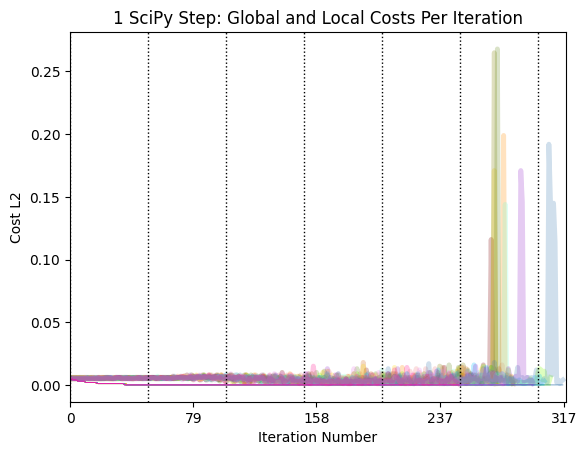

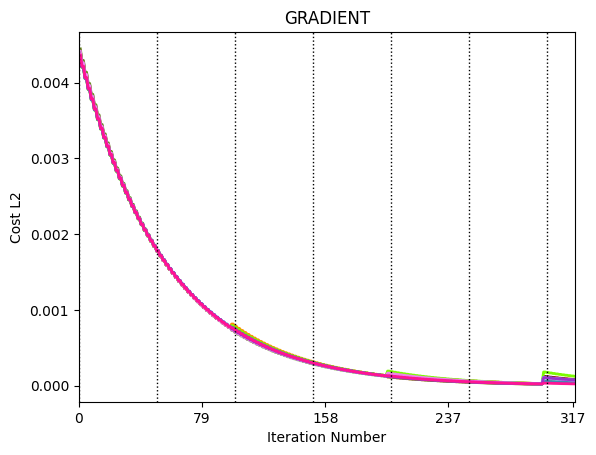

In [36]:
user_c0_1ScipyStep = [Client1(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', local_round_threshold=50, delay_scaling=0) for i in range(14)]
global_model_1scipystep = Server1(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
ceplotting(user_c0_1ScipyStep, 'local', dim_reduc_factor=1, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
ceplotting(user_c0_1ScipyStep, 'local', plot_gradient=True, dim_reduc_factor=1, local_error=False, global_error=False, custom_title='GRADIENT')

## Commit e6e9e18

In [16]:
class Server2(ModelBase):
    def __init__(self, ID, D0, method, all_clients, smoothbatch=1, C=0.1, normalize_dec=True, current_round=0, PCA_comps=7, verbose=False, experimental_plotting=False, num_steps=10):
        super().__init__(ID, D0, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose, num_participants=14, log_init=0)
        self.type = 'Server'
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(all_clients)
        self.num_chosen_clients = 0
        self.chosen_clients_lst = [0]*len(all_clients)
        self.all_clients = all_clients
        self.C = C  # Fraction of clients to use each round
        self.experimental_plotting = False
        self.experimental_inclusion_round = [0]
        self.init_lst = [self.log_init]*self.num_participants
        self.normalize_dec = normalize_dec
        self.set_available_clients_list(init=True)

                
    # 0: Main Loop
    def execute_FL_loop(self):
        # Update global round number
        self.current_round += 1
        
        if self.method=='FedAvg':
            # Choose fraction C of available clients
            self.set_available_clients_list()
            self.choose_clients()
            # Send those clients the current global model
            if self.experimental_plotting:
                for my_client in self.available_clients_lst:
                    if my_client in self.chosen_clients_lst:
                        my_client.global_w = self.w
                    else:
                        my_client.local_error_log.append(my_client.local_error_log[-1])
                        my_client.global_error_log.append(my_client.global_error_log[-1])    
                        my_client.personalized_error_log.append(my_client.personalized_error_log[-1])    
            else:
                for my_client in self.chosen_clients_lst:
                    my_client.global_w = self.w
            # Let those clients train (this autoselects the chosen_client_lst to use)
            self.train_client_and_log(client_set=self.chosen_clients_lst)
            # AGGREGATION
            self.w_prev = copy.copy(self.w)
            self.agg_local_weights()  # This func sets self.w, eg the new decoder
            # GLOBAL SmoothBatch
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
            #^ Note when self.smoothbatch=1 (default), we just keep the new self.w (no mixing)
        elif self.method=='NoFL':
            self.train_client_and_log(client_set=self.all_clients)
        else:
            raise('Method not currently supported, please reset method to FedAvg')
        # Save the new decoder to the log
        self.dec_log.append(self.w)
        # Reset all clients so no one is chosen for the next round
        for my_client in self.all_clients:  # Would it be better to use just the chosen_clients or do all_clients?
            if type(my_client)==int:
                raise("All my clients are all integers...")
            my_client.chosen_status = 0
        
    # 1.1
    def set_available_clients_list(self, init=False):
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(self.all_clients)
        for idx, my_client in enumerate(self.all_clients):
            if my_client.availability:
                self.available_clients_lst[idx] = my_client
                self.num_avail_clients += 1
                if init:
                    #if self.method != 'NoFL':
                    # Pass down the global METHOD (NOT THE WEIGHTS!!)
                    my_client.global_method = self.method
    
    # 1.2
    def choose_clients(self):
        # Check what client are available this round
        self.set_available_clients_list()
        # Now choose frac C clients from the resulting available clients
        if self.num_avail_clients > 0:
            self.num_chosen_clients = int(np.ceil(self.num_avail_clients*self.C))
            if self.num_chosen_clients<1:
                raise(f"ERROR: Chose {self.num_chosen_clients} clients for some reason, must choose more than 1")
            # Right now it chooses 2 at random: 14*.1=1.4 --> 2
            self.chosen_clients_lst = random.sample(self.available_clients_lst, len(self.available_clients_lst))[:self.num_chosen_clients]
            for my_client in self.chosen_clients_lst:
                my_client.chosen_status = 1
        else:
            raise(f"ERROR: Number of available clients must be greater than 0: {self.num_avail_clients}")
        
    # 2
    def train_client_and_log(self, client_set):
        current_local_lst = []
        current_global_lst = []
        current_pers_lst = []
        for my_client in self.available_clients_lst:  # Implications of using this instead of all_clients?
            my_client.current_global_round = self.current_round
            #^ Need to overwrite client with the curernt global round, for t later
            
            # This isn't great code because it checks the init every single time it runs
            #  Maybe move this to be before this loop?
            if self.local_error_log[-1]==self.log_init:
                local_init_carry_val = 0
                global_init_carry_val = 0
                pers_init_carry_val = 0
            else:
                local_init_carry_val = self.local_error_log[-1][my_client.ID][2]#[0]
                if self.method != 'NoFL':
                    global_init_carry_val = self.global_error_log[-1][my_client.ID][2]#[0]
            if my_client in client_set:
                my_client.execute_training_loop()
                current_local_lst.append((my_client.ID, self.current_round, 
                                          my_client.eval_model(which='local')))
                if self.method != 'NoFL':
                    current_global_lst.append((my_client.ID, self.current_round, 
                                               my_client.eval_model(which='global')))
                if self.method == 'APFL':
                    current_pers_lst.append((my_client.ID, self.current_round, 
                                               my_client.eval_model(which='pers')))
            else:
                current_local_lst.append((my_client.ID, self.current_round, 
                                          local_init_carry_val))
                if self.method != 'NoFL':
                    current_global_lst.append((my_client.ID, self.current_round,
                                               global_init_carry_val))
                if self.method == 'APFL':
                    current_pers_lst.append((my_client.ID, self.current_round,
                                               pers_init_carry_val))
        # Append (ID, COST) to SERVER'S error log.  
        #  Note that round is implicit, it is just the index of the error log
        if self.local_error_log==self.init_lst:
            # Overwrite the [(0,0)] hold
            self.local_error_log = []
            self.local_error_log.append(current_local_lst)
        else:
            self.local_error_log.append(current_local_lst)
        if self.method != 'NoFL':
            # NoFL case has no global model since there's... no FL
            if self.global_error_log==self.init_lst:
                self.global_error_log = []
                self.global_error_log.append(current_global_lst)
            else:
                self.global_error_log.append(current_global_lst)
    
    # 3
    def agg_local_weights(self):
        # From McMahan 2017 (vanilla FL)
        summed_num_datapoints = 0
        for my_client in self.chosen_clients_lst:
            summed_num_datapoints += my_client.learning_batch
        # Aggregate local model weights, weighted by normalized local learning rate
        aggr_w = 0
        for my_client in self.chosen_clients_lst:
            if self.normalize_dec:
                normalization_term = np.amax(my_client.w)
            else:
                normalization_term = 1
            aggr_w += (my_client.learning_batch/summed_num_datapoints) * my_client.w / normalization_term
        if self.normalize_dec:
            aggr_w /= np.amax(aggr_w)
        self.w = aggr_w
        
    # Function for getting the finalized personalized and global model 
    def set_finalized_APFL_models(self):
        # Defining params used in the next section
        for t in range(T):
            summed_chosen_globals = np.sum([chosen_client.global_w for chosen_client in self.chosen_clients_lst])
            for my_client in self.available_clients_lst:
                my_client.running_pers_term += my_client.p[t]*(my_client.adap_alpha*my_client.local_w + (1-my_client.adap_alpha)*(1/K)*summed_chosen_globals) 
                my_client.running_global_term += my_client.p[t]*summed_chosen_globals
        # The actual models                                                    
        # "tin for i=1,...,n"
        for my_client in self.available_clients_lst:
            S_T = np.sum(my_client.p)
            # All these random params are defined in theorem 2 on Page 10
            # "Output" --> lol and do what with
            # Personalized model: v^hat AKA personalized_w = (1/S_T)*\sum_1^T(p_t(alpha_i*v_i^t + (1-alpha_i)*(1/K)*(\sum_{j in chosen clients} w_j^t)))
            my_client.final_personalized_w = (1/S_T)*my_client.running_pers_term
            # Global model: w^hat = 1/(K*S_T)*(\sum_1^T p_t*(\sum_j w_j^t))
            my_client.final_global_w = (1/K*S_T)*my_client.running_global_term
                                                               

class Client2(ModelBase, TrainingMethods):
    def __init__(self, ID, w, method, local_data, data_stream, smoothbatch=1, current_round=0, PCA_comps=7, availability=1, global_method='FedAvg', normalize_dec=False, track_cost_components=True, gradient_clipping=False, clipping_threshold=100, tol=1e-10, adaptive=True, eta=1, track_gradient=True, num_steps=1, input_eta=False, safe_lr=False, delay_scaling=5, normalize_EMG=True, random_delays=False, download_delay=1, upload_delay=1, local_round_threshold=50, condition_number=0, verbose=False):
        super().__init__(ID, w, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose, num_participants=14, log_init=0)
        '''
        Note self.smoothbatch gets overwritten according to the condition number!  
        If you want NO smoothbatch then set it to 'off'
        '''
        # NOT INPUT
        self.type = 'Client'
        self.chosen_status = 0
        self.current_global_round = 0
        self.update_transition_log = []
        self.normalize_EMG = normalize_EMG
        # Sentinel Values
        self.F = None
        self.V = None
        self.D = None
        self.H = np.zeros((2,2))
        self.learning_batch = None
        self.dt = 1.0/60.0
        self.eta = eta
        self.training_data = local_data['training']
        self.labels = local_data['labels']
        # Round minimization output to the nearest int or keep as a float?  Don't need arbitrary precision
        self.round2int = False
        self.normalize_dec = normalize_dec
        # FL CLASS STUFF
        # Availability for training
        self.availability = availability
        # Toggle streaming aspect of data collection: {Ignore updates and use all the data; 
        #  Stream each update, moving to the next update after local_round_threshold iters have been run; 
        #  After 1 iteration, move to the next update}
        self.data_stream = data_stream  # {'full_data', 'streaming', 'advance_each_iter'} 
        # Number of gradient steps to take when training (eg amount of local computation)
        self.num_steps = num_steps
        # GLOBAL STUFF
        self.global_w = None
        self.global_method = global_method
        # UPDATE STUFF
        if self.global_method=='NoFL':
            starting_update = 0
        else:
            starting_update = self.cphs_starting_update
        self.current_update = starting_update
        self.local_round_threshold = local_round_threshold
        self.current_threshold = local_round_threshold
        #
        # Not even using the delay stuff right now
        # Boolean setting whether or not up/download delays should be random or predefined
        self.random_delays = random_delays
        # Scaling from random [0,1] to number of seconds
        self.delay_scaling = delay_scaling
        # Set the delay times
        if self.random_delays: 
            self.download_delay = random.random()*self.delay_scaling
            self.upload_delay = random.random()*self.delay_scaling
        else:
            self.download_delay = download_delay
            self.upload_delay = upload_delay
        #
        # ML Parameters / Conditions
        self.alphaE = 1e-6
        # This should probably be a dictionary at some point
        if condition_number==0:
            self.smoothbatch = 0.25
            self.alphaF = 1e-7
            self.alphaD = 1e-3
        else:
            print("That condition number is not yet supported")
        if smoothbatch=='off':
            self.smoothbatch = 1  # AKA Use only the new dec, no mixing
        # PLOTTING
        # ^Eg the local round is implicit, it can't have a skip in round
        # Overwrite the logs since global and local track in slightly different ways
        self.local_error_log = [0]
        self.global_error_log = [0]
        self.personalized_error_log = [0]
        self.performance_log = [0]
        self.Dnorm_log = [0]
        self.Fnorm_log = [0]
        self.gradient_log = [0]
        self.track_cost_components = track_cost_components
        self.track_gradient = track_gradient
        
                                                               
    # 0: Main Loop
    def execute_training_loop(self):
        self.simulate_data_stream()
        self.train_model()
        
        # Append (ROUND, COST) to the CLIENT error log
        local_loss = self.eval_model(which='local')
        self.local_error_log.append(local_loss)  # ((self.current_round, local_loss))
        # Yes these should both be ifs, they may both need to run
        if self.global_method!="NoFL":
            global_loss = self.eval_model(which='global')
            self.global_error_log.append(global_loss)  # ((self.current_round, global_loss))
        if self.global_method=="APFL":
            pers_loss = self.eval_model(which='pers')
            self.personalized_error_log.append(pers_loss)  # ((self.current_round, pers_loss))
        D = self.mixed_model if self.global_method=='APFL' else self.w
        if self.track_cost_components:
            self.performance_log.append(self.alphaE*(np.linalg.norm((D@self.F + self.H@self.V[:,:-1] - self.V[:,1:]))**2))
            self.Dnorm_log.append(self.alphaD*(np.linalg.norm(D)**2))
            self.Fnorm_log.append(self.alphaF*(np.linalg.norm(self.F)**2))
        if self.track_gradient:
            # The gradient is a vector... So let's just save the L2 norm?
            self.gradient_log.append(np.linalg.norm(gradient_cost_l2(self.F, D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)))

        
    def simulate_delay(self, incoming):
        if incoming:
            time.sleep(self.download_delay+random.random())
        else:
            time.sleep(self.upload_delay+random.random())
            
    def simulate_data_stream(self, streaming_method=True):
        if streaming_method:
            streaming_method = self.data_stream
        need_to_advance=True
        self.current_round += 1
        if self.current_update==16:  #17: previously 17 but the last update is super short so I cut it out
            #print("Maxxed out your update (you are on update 18), continuing training on last update only")
            # Probably ought to track that we maxed out --> LOG SYSTEM
            # We are stopping an update early, so use -3/-2 and not -2/-1 (the last update)
            lower_bound = (update_ix[-3] + update_ix[-2])//2  #Use only the second half of each update
            upper_bound = update_ix[-2]
            self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='full_data':
            lower_bound = update_ix[0]  # Starts at 0 and not update 10, for now
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='streaming':
            # If we pass threshold, move on to the next update
            # Why don't I just use modulus here?
            if self.current_round >= self.current_threshold:
                self.current_threshold += self.local_round_threshold
                
                ####################################################
                # This is such a janky solution lol
                self.prev_update = self.current_update
                self.current_update = self.prev_update + 1
                
                self.update_transition_log.append(self.current_global_round)
                if self.verbose==True and self.ID==1:
                    print(f"Client {self.ID}: New update after lrt passed: (new update, current global round, current local round): {self.current_update, self.current_global_round, self.current_round}")
                    print()
                    
                # Using only the second half of each update for co-adaptivity reasons
                lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
                upper_bound = update_ix[self.current_update+1]
                self.learning_batch = upper_bound - lower_bound
            elif self.current_round>2:
                # This is the base case
                # The update number didn't change so we don't need to overwrite everything with the same data
                need_to_advance = False
            else:
                # This is for the init case (current round is 0 or 1)
                # need_to_advance is true, so we overwrite s and such... this is fine 
                lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
                upper_bound = update_ix[self.current_update+1]
                self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='advance_each_iter':
            lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
            
            ####################################################
            self.prev_update = self.current_update
            self.current_update = self.prev_update + 1
        else:
            raise ValueError(f'streaming_method ("{streaming_method}") not recognized: this data streaming functionality is not supported')
            
        if need_to_advance:
            s_temp = self.training_data[lower_bound:upper_bound,:]
            # First, normalize the entire s matrix
            if self.normalize_EMG:
                s_normed = s_temp/np.amax(s_temp)
            else:
                s_normed = s_temp
            # Now do PCA unless it is set to 64 (AKA the default num channels i.e. no reduction)
            # Also probably ought to find a global transform if possible so I don't recompute it every time...
            if self.PCA_comps!=self.pca_channel_default:  
                pca = PCA(n_components=self.PCA_comps)
                s_normed = pca.fit_transform(s_normed)
            s = np.transpose(s_normed)
            v_actual = self.w@s
            p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
            p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
            # Now set the values used in the cost function
            self.F = s[:,:-1] # note: truncate F for estimate_decoder
            self.V = (p_reference - p_actual)*self.dt
            if self.global_method=='APFL':
                self.Vglobal = (p_reference - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
                #self.Vlocal = (p_reference - np.cumsum(self.w@s, axis=1)*self.dt)*self.dt  
                # ^Here, Vlocal is just self.V! Same eqn
                # ^Should this be local or mixed? I think local... 
                # ^Even though it is evaluated at the mixed dec... not sure
                # For V that is used with mixed I think it should actually be mixed.  Makes more sense
                self.Vmixed = (p_reference - np.cumsum(self.mixed_w@s, axis=1)*self.dt)*self.dt
            self.D = copy.copy(self.w)
    
    def train_model(self):
        D_0 = self.w_prev
        # Set the w_prev equal to the current w:
        self.w_prev = self.w
        if self.global_method=="FedAvg":
            # Overwrite local model with the new global model
            self.w = self.global_w
        if self.global_method=="FedAvg" or self.global_method=="NoFL":
            for i in range(self.num_steps):
                ########################################
                # Should I normalize the dec here?  
                # I think this will prevent it from blowing up if I norm it every time
                if self.normalize_dec:
                    self.w /= np.amax(self.w)
                ########################################
                if self.method=='EtaGradStep':
                    self.w = self.train_eta_gradstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, PCA_comps=self.PCA_comps)
                elif self.method=='EtaScipyMinStep':
                    self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps)
                elif self.method=='FullScipyMinStep':
                    self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps, full=True)
                else:
                    raise ValueError("Unrecognized method")
            ########################################
            # Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
            if self.normalize_dec:
                self.w /= np.amax(self.w)
            ########################################
            # Do SmoothBatch
            # Maybe move this to only happen after each update? Does it really need to happen every iter?
            # I'd have to add weird flags just for this in various places... put on hold for now
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
        # Save the new decoder to the log
        #self.dec_log.append(self.mixed_w)
        # It should only be saving mixed_w for the pers algos... not FedAvg...
        
    def eval_model(self, which):
        if which=='local':
            my_dec = self.w
            #my_error_log = self.local_error_log
        elif which=='global':
            my_dec = self.global_w
            #my_error_log = self.global_error_log
        elif which=='pers' and self.global_method=='APFL':
            my_dec = self.mixed_w
        else:
            print("Please set <which> to either local or global")
        # Just did this so we wouldn't have the 14 decimals points it always tries to give
        if self.round2int:
            temp = np.ceil(cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD))
            # Setting to int is just to catch overflow errors
            # For RT considerations, ints are also generally ints cheaper than floats...
            out = int(temp)
        else:
            temp = cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
            out = round(temp, 3)
        return out
        
    def test_inference(self, test_dec=True):
        ''' No training / optimization, this just tests the fed in dec '''
        
        if test_dec:
            test_dec = self.w
        # This sets FVD using the full client dataset
        # Since we aren't doing any optimization then it shouldn't matter if we use updates or not...
        simulate_data_stream(streaming_method='full_data')
        # Evaluate cost
        temp = cost_l2(self.F, test_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
        dec_cost = round(temp, 3)
        # Also want to see actual output 
        # This might be the cost and not the actual position...
        D_reshaped = np.reshape(test_dec,(2,self.PCA_comps))
        dec_pos = D_reshaped@self.F + self.H@self.V[:,:-1] - self.V[:,1:]
        return dec_cost, dec_pos

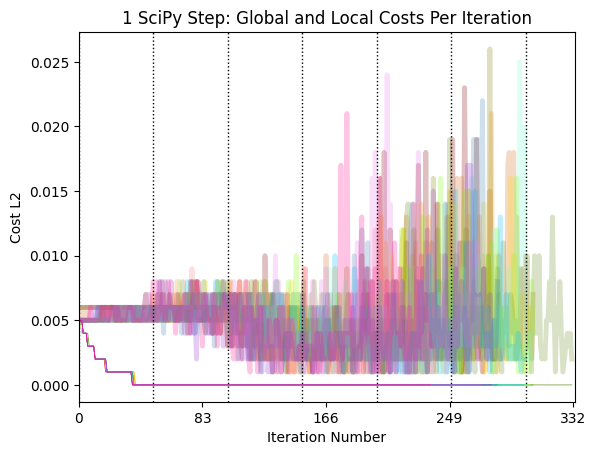

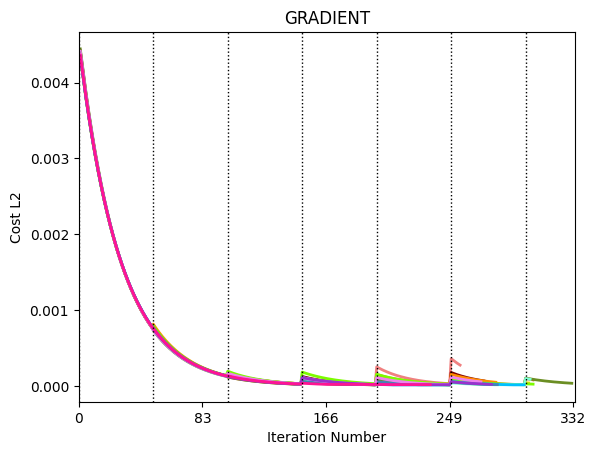

In [17]:
user_c0_1ScipyStep = [Client2(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model_1scipystep = Server2(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
ceplotting(user_c0_1ScipyStep, 'local', dim_reduc_factor=1, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
ceplotting(user_c0_1ScipyStep, 'local', plot_gradient=True, dim_reduc_factor=1, local_error=False, global_error=False, custom_title='GRADIENT')

With fl_sim_classes init

In [30]:
class Server3(ModelBase):
    def __init__(self, ID, D0, method, all_clients, smoothbatch=1, C=0.1, normalize_dec=True, current_round=0, PCA_comps=7, verbose=False, experimental_plotting=False, num_steps=10):
        super().__init__(ID, D0, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose, num_participants=14, log_init=0)
        self.type = 'Server'
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(all_clients)
        self.num_chosen_clients = 0
        self.chosen_clients_lst = [0]*len(all_clients)
        self.all_clients = all_clients
        self.C = C  # Fraction of clients to use each round
        self.experimental_plotting = False
        self.experimental_inclusion_round = [0]
        self.init_lst = [self.log_init]*self.num_participants
        self.normalize_dec = normalize_dec
        self.set_available_clients_list(init=True)

                
    # 0: Main Loop
    def execute_FL_loop(self):
        # Update global round number
        self.current_round += 1
        
        if self.method=='FedAvg':
            # Choose fraction C of available clients
            self.set_available_clients_list()
            self.choose_clients()
            # Send those clients the current global model
            if self.experimental_plotting:
                for my_client in self.available_clients_lst:
                    if my_client in self.chosen_clients_lst:
                        my_client.global_w = self.w
                    else:
                        my_client.local_error_log.append(my_client.local_error_log[-1])
                        my_client.global_error_log.append(my_client.global_error_log[-1])    
                        my_client.personalized_error_log.append(my_client.personalized_error_log[-1])    
            else:
                for my_client in self.chosen_clients_lst:
                    my_client.global_w = self.w
            # Let those clients train (this autoselects the chosen_client_lst to use)
            self.train_client_and_log(client_set=self.chosen_clients_lst)
            # AGGREGATION
            self.w_prev = copy.copy(self.w)
            self.agg_local_weights()  # This func sets self.w, eg the new decoder
            # GLOBAL SmoothBatch
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
            #^ Note when self.smoothbatch=1 (default), we just keep the new self.w (no mixing)
        elif self.method=='NoFL':
            self.train_client_and_log(client_set=self.all_clients)
        else:
            raise('Method not currently supported, please reset method to FedAvg')
        # Save the new decoder to the log
        self.dec_log.append(self.w)
        # Reset all clients so no one is chosen for the next round
        for my_client in self.all_clients:  # Would it be better to use just the chosen_clients or do all_clients?
            if type(my_client)==int:
                raise("All my clients are all integers...")
            my_client.chosen_status = 0
        
    # 1.1
    def set_available_clients_list(self, init=False):
        self.num_avail_clients = 0
        self.available_clients_lst = [0]*len(self.all_clients)
        for idx, my_client in enumerate(self.all_clients):
            if my_client.availability:
                self.available_clients_lst[idx] = my_client
                self.num_avail_clients += 1
                if init:
                    #if self.method != 'NoFL':
                    # Pass down the global METHOD (NOT THE WEIGHTS!!)
                    my_client.global_method = self.method
    
    # 1.2
    def choose_clients(self):
        # Check what client are available this round
        self.set_available_clients_list()
        # Now choose frac C clients from the resulting available clients
        if self.num_avail_clients > 0:
            self.num_chosen_clients = int(np.ceil(self.num_avail_clients*self.C))
            if self.num_chosen_clients<1:
                raise(f"ERROR: Chose {self.num_chosen_clients} clients for some reason, must choose more than 1")
            # Right now it chooses 2 at random: 14*.1=1.4 --> 2
            self.chosen_clients_lst = random.sample(self.available_clients_lst, len(self.available_clients_lst))[:self.num_chosen_clients]
            for my_client in self.chosen_clients_lst:
                my_client.chosen_status = 1
        else:
            raise(f"ERROR: Number of available clients must be greater than 0: {self.num_avail_clients}")
        
    # 2
    def train_client_and_log(self, client_set):
        current_local_lst = []
        current_global_lst = []
        current_pers_lst = []
        for my_client in self.available_clients_lst:  # Implications of using this instead of all_clients?
            my_client.current_global_round = self.current_round
            #^ Need to overwrite client with the curernt global round, for t later
            
            # This isn't great code because it checks the init every single time it runs
            #  Maybe move this to be before this loop?
            if self.local_error_log[-1]==self.log_init:
                local_init_carry_val = 0
                global_init_carry_val = 0
                pers_init_carry_val = 0
            else:
                local_init_carry_val = self.local_error_log[-1][my_client.ID][2]#[0]
                if self.method != 'NoFL':
                    global_init_carry_val = self.global_error_log[-1][my_client.ID][2]#[0]
                if self.method == 'APFL':
                    pers_init_carry_val = self.personalized_error_log[-1][my_client.ID][2]#[0]
            if my_client in client_set:
                my_client.execute_training_loop()
                current_local_lst.append((my_client.ID, self.current_round, 
                                          my_client.eval_model(which='local')))
                if self.method != 'NoFL':
                    current_global_lst.append((my_client.ID, self.current_round, 
                                               my_client.eval_model(which='global')))
                if self.method == 'APFL':
                    current_pers_lst.append((my_client.ID, self.current_round, 
                                               my_client.eval_model(which='pers')))
            else:
                current_local_lst.append((my_client.ID, self.current_round, 
                                          local_init_carry_val))
                if self.method != 'NoFL':
                    current_global_lst.append((my_client.ID, self.current_round,
                                               global_init_carry_val))
                if self.method == 'APFL':
                    current_pers_lst.append((my_client.ID, self.current_round,
                                               pers_init_carry_val))
        # Append (ID, COST) to SERVER'S error log.  
        #  Note that round is implicit, it is just the index of the error log
        if self.local_error_log==self.init_lst:
            # Overwrite the [(0,0)] hold
            self.local_error_log = []
            self.local_error_log.append(current_local_lst)
        else:
            self.local_error_log.append(current_local_lst)
        if self.method != 'NoFL':
            # NoFL case has no global model since there's... no FL
            if self.global_error_log==self.init_lst:
                self.global_error_log = []
                self.global_error_log.append(current_global_lst)
            else:
                self.global_error_log.append(current_global_lst)

    
    # 3
    def agg_local_weights(self):
        # From McMahan 2017 (vanilla FL)
        summed_num_datapoints = 0
        for my_client in self.chosen_clients_lst:
            summed_num_datapoints += my_client.learning_batch
        # Aggregate local model weights, weighted by normalized local learning rate
        aggr_w = 0
        for my_client in self.chosen_clients_lst:
            if self.normalize_dec:
                normalization_term = np.amax(my_client.w)
            else:
                normalization_term = 1
            aggr_w += (my_client.learning_batch/summed_num_datapoints) * my_client.w / normalization_term
        if self.normalize_dec:
            aggr_w /= np.amax(aggr_w)
        self.w = aggr_w
        
    # Function for getting the finalized personalized and global model 
    def set_finalized_APFL_models(self):
        # Defining params used in the next section
        for t in range(T):
            summed_chosen_globals = np.sum([chosen_client.global_w for chosen_client in self.chosen_clients_lst])
            for my_client in self.available_clients_lst:
                my_client.running_pers_term += my_client.p[t]*(my_client.adap_alpha*my_client.local_w + (1-my_client.adap_alpha)*(1/K)*summed_chosen_globals) 
                my_client.running_global_term += my_client.p[t]*summed_chosen_globals
        # The actual models                                                    
        # "tin for i=1,...,n"
        for my_client in self.available_clients_lst:
            S_T = np.sum(my_client.p)
            # All these random params are defined in theorem 2 on Page 10
            # "Output" --> lol and do what with
            # Personalized model: v^hat AKA personalized_w = (1/S_T)*\sum_1^T(p_t(alpha_i*v_i^t + (1-alpha_i)*(1/K)*(\sum_{j in chosen clients} w_j^t)))
            my_client.final_personalized_w = (1/S_T)*my_client.running_pers_term
            # Global model: w^hat = 1/(K*S_T)*(\sum_1^T p_t*(\sum_j w_j^t))
            my_client.final_global_w = (1/K*S_T)*my_client.running_global_term
                                                               

class Client3(ModelBase, TrainingMethods):
    def __init__(self, ID, w, method, local_data, data_stream, smoothbatch=1, current_round=0, PCA_comps=7, availability=1, global_method='FedAvg', normalize_dec=False, normalize_EMG=True, track_cost_components=True, track_lr_comps=True, use_real_hess=True, gradient_clipping=False, log_decs=True, clipping_threshold=100, tol=1e-10, adaptive=True, eta=1, track_gradient=True, num_steps=1, input_eta=False, safe_lr_factor=False, mix_in_each_steps=False, mix_mixed_SB=False, delay_scaling=5, random_delays=False, download_delay=1, upload_delay=1, local_round_threshold=50, condition_number=1, verbose=False):
        super().__init__(ID, w, method, smoothbatch=smoothbatch, current_round=current_round, PCA_comps=PCA_comps, verbose=verbose, num_participants=14, log_init=0)
        '''
        Note self.smoothbatch gets overwritten according to the condition number!  
        If you want NO smoothbatch then set it to 'off'
        '''
        # NOT INPUT
        self.type = 'Client'
        self.chosen_status = 0
        self.current_global_round = 0
        self.update_transition_log = []
        self.normalize_EMG = normalize_EMG
        # Sentinel Values
        self.F = None
        self.V = None
        self.D = None
        self.H = np.zeros((2,2))
        self.learning_batch = None
        self.dt = 1.0/60.0
        self.eta = eta
        self.training_data = local_data['training']
        self.labels = local_data['labels']
        # Round minimization output to the nearest int or keep as a float?  Don't need arbitrary precision
        self.round2int = False
        self.normalize_dec = normalize_dec
        # FL CLASS STUFF
        # Availability for training
        self.availability = availability
        # Toggle streaming aspect of data collection: {Ignore updates and use all the data; 
        #  Stream each update, moving to the next update after local_round_threshold iters have been run; 
        #  After 1 iteration, move to the next update}
        self.data_stream = data_stream  # {'full_data', 'streaming', 'advance_each_iter'} 
        # Number of gradient steps to take when training (eg amount of local computation)
        self.num_steps = num_steps
        # GLOBAL STUFF
        self.global_method = global_method
        # UPDATE STUFF
        if self.global_method=='NoFL':
            starting_update = 0
        else:
            starting_update = self.cphs_starting_update
        self.current_update = starting_update
        self.local_round_threshold = local_round_threshold
        self.current_threshold = local_round_threshold
        #
        # Not even using the delay stuff right now
        # Boolean setting whether or not up/download delays should be random or predefined
        self.random_delays = random_delays
        # Scaling from random [0,1] to number of seconds
        self.delay_scaling = delay_scaling
        # Set the delay times
        if self.random_delays: 
            self.download_delay = random.random()*self.delay_scaling
            self.upload_delay = random.random()*self.delay_scaling
        else:
            self.download_delay = download_delay
            self.upload_delay = upload_delay
        #
        # ML Parameters / Conditions        
        cond_dict = {1:(0.25, 1e-3, 1), 2:(0.25, 1e-4, 1), 3:(0.75, 1e-3, 1), 4:(0.75, 1e-4, 1), 5:(0.25, 1e-4, -1), 6:(0.25, 1e-4, -1), 7:(0.75, 1e-3, -1), 8:(0.75, 1e-4, -1)}
        cond_smoothbatch, self.alphaD, self.init_dec_sign = cond_dict[condition_number]
        if type(smoothbatch)==str and smoothbatch.upper()=='OFF':
            self.smoothbatch = 1  # AKA Use only the new dec, no mixing
        elif smoothbatch==1:  # This is the default
            # If it is default, then let the condition number set smoothbatch
            self.smoothbatch = cond_smoothbatch
        else:
            # Set smoothbatch to whatever you manually entered
            self.smoothbatch=smoothbatch
            print()
        self.alphaE = 1e-6
        self.alphaF = 1e-7
        #
        self.gradient_clipping = gradient_clipping
        self.clipping_threshold = clipping_threshold
        # PLOTTING
        self.log_decs = log_decs
        self.pers_dec_log = []
        self.global_dec_log = []
        # Overwrite the logs since global and local track in slightly different ways
        self.local_error_log = []
        self.global_error_log = []
        self.personalized_error_log = []
        self.track_cost_components = track_cost_components
        self.performance_log = []
        self.Dnorm_log = []
        self.Fnorm_log = []
        self.track_gradient = track_gradient
        self.gradient_log = []
        self.pers_gradient_log = []
        self.global_gradient_log = []
        # FedAvgSB Stuff
        self.mix_in_each_steps = mix_in_each_steps
        self.mix_mixed_SB = mix_mixed_SB
        self.input_eta = input_eta  # Is this really an APFL thing only?
        # These are general personalization things
        self.running_pers_term = 0
        self.running_global_term = 0
        self.global_w = copy.copy(self.w)
        self.mixed_w = copy.copy(self.w)
        # APFL Stuff
        self.tol = tol 
        self.track_lr_comps = track_lr_comps
        self.L_log = []
        self.mu_log = []
        self.eta_t_log = []
        self.adaptive = adaptive
        #They observed best results with 0.25, but initialized adap_alpha to 0.01 for the adaptive case
        if self.adaptive:
            self.adap_alpha = [0.01]  
        else:
            self.adap_alpha = [0.25] 
        self.tau = self.num_steps # This is just an init... it really ought to pull it from global...
        self.p = [0]
        self.safe_lr_factor = safe_lr_factor
        self.Vmixed = None
        self.Vglobal = None
        self.use_real_hess = use_real_hess
        self.prev_update = None
        self.prev_eigvals = None

                                                               
    # 0: Main Loop
    def execute_training_loop(self):
        self.simulate_data_stream()
        self.train_model()
        
        # Append (ROUND, COST) to the CLIENT error log
        local_loss = self.eval_model(which='local')
        self.local_error_log.append(local_loss)  # ((self.current_round, local_loss))
        # Yes these should both be ifs, they may both need to run
        if self.global_method!="NoFL":
            global_loss = self.eval_model(which='global')
            self.global_error_log.append(global_loss)  # ((self.current_round, global_loss))
        if self.global_method=="APFL":
            pers_loss = self.eval_model(which='pers')
            self.personalized_error_log.append(pers_loss)  # ((self.current_round, pers_loss))
        D = self.mixed_model if self.global_method=='APFL' else self.w
        if self.track_cost_components:
            self.performance_log.append(self.alphaE*(np.linalg.norm((D@self.F + self.H@self.V[:,:-1] - self.V[:,1:]))**2))
            self.Dnorm_log.append(self.alphaD*(np.linalg.norm(D)**2))
            self.Fnorm_log.append(self.alphaF*(np.linalg.norm(self.F)**2))
        if self.track_gradient:
            # The gradient is a vector... So let's just save the L2 norm?
            self.gradient_log.append(np.linalg.norm(gradient_cost_l2(self.F, D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)))

        
    def simulate_delay(self, incoming):
        if incoming:
            time.sleep(self.download_delay+random.random())
        else:
            time.sleep(self.upload_delay+random.random())
            
    def simulate_data_stream(self, streaming_method=True):
        if streaming_method:
            streaming_method = self.data_stream
        need_to_advance=True
        self.current_round += 1
        if self.current_update==16:  #17: previously 17 but the last update is super short so I cut it out
            #print("Maxxed out your update (you are on update 18), continuing training on last update only")
            # Probably ought to track that we maxed out --> LOG SYSTEM
            # We are stopping an update early, so use -3/-2 and not -2/-1 (the last update)
            lower_bound = (update_ix[-3] + update_ix[-2])//2  #Use only the second half of each update
            upper_bound = update_ix[-2]
            self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='full_data':
            lower_bound = update_ix[0]  # Starts at 0 and not update 10, for now
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='streaming':
            # If we pass threshold, move on to the next update
            # Why don't I just use modulus here?
            if self.current_round >= self.current_threshold:
                self.current_threshold += self.local_round_threshold
                
                ####################################################
                # This is such a janky solution lol
                self.prev_update = self.current_update
                self.current_update = self.prev_update + 1
                
                self.update_transition_log.append(self.current_global_round)
                if self.verbose==True and self.ID==1:
                    print(f"Client {self.ID}: New update after lrt passed: (new update, current global round, current local round): {self.current_update, self.current_global_round, self.current_round}")
                    print()
                    
                # Using only the second half of each update for co-adaptivity reasons
                lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
                upper_bound = update_ix[self.current_update+1]
                self.learning_batch = upper_bound - lower_bound
            elif self.current_round>2:
                # This is the base case
                # The update number didn't change so we don't need to overwrite everything with the same data
                need_to_advance = False
            else:
                # This is for the init case (current round is 0 or 1)
                # need_to_advance is true, so we overwrite s and such... this is fine 
                lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
                upper_bound = update_ix[self.current_update+1]
                self.learning_batch = upper_bound - lower_bound
        elif streaming_method=='advance_each_iter':
            lower_bound = (update_ix[self.current_update] + update_ix[self.current_update+1])//2  
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
            
            ####################################################
            self.prev_update = self.current_update
            self.current_update = self.prev_update + 1
        else:
            raise ValueError(f'streaming_method ("{streaming_method}") not recognized: this data streaming functionality is not supported')
            
        if need_to_advance:
            s_temp = self.training_data[lower_bound:upper_bound,:]
            # First, normalize the entire s matrix
            if self.normalize_EMG:
                s_normed = s_temp/np.amax(s_temp)
            else:
                s_normed = s_temp
            # Now do PCA unless it is set to 64 (AKA the default num channels i.e. no reduction)
            # Also probably ought to find a global transform if possible so I don't recompute it every time...
            if self.PCA_comps!=self.pca_channel_default:  
                pca = PCA(n_components=self.PCA_comps)
                s_normed = pca.fit_transform(s_normed)
            s = np.transpose(s_normed)
            v_actual = self.w@s
            p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
            p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
            # Now set the values used in the cost function
            self.F = s[:,:-1] # note: truncate F for estimate_decoder
            self.V = (p_reference - p_actual)*self.dt
            if self.global_method=='APFL':
                self.Vglobal = (p_reference - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
                #self.Vlocal = (p_reference - np.cumsum(self.w@s, axis=1)*self.dt)*self.dt  
                # ^Here, Vlocal is just self.V! Same eqn
                # ^Should this be local or mixed? I think local... 
                # ^Even though it is evaluated at the mixed dec... not sure
                # For V that is used with mixed I think it should actually be mixed.  Makes more sense
                self.Vmixed = (p_reference - np.cumsum(self.mixed_w@s, axis=1)*self.dt)*self.dt
            self.D = copy.copy(self.w)
    
    def train_model(self):
        D_0 = self.w_prev
        # Set the w_prev equal to the current w:
        self.w_prev = self.w
        if self.global_method=="FedAvg":
            # Overwrite local model with the new global model
            self.w = self.global_w
        if self.global_method=="FedAvg" or self.global_method=="NoFL":
            for i in range(self.num_steps):
                ########################################
                # Should I normalize the dec here?  
                # I think this will prevent it from blowing up if I norm it every time
                if self.normalize_dec:
                    self.w /= np.amax(self.w)
                ########################################
                if self.method=='EtaGradStep':
                    self.w = self.train_eta_gradstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, PCA_comps=self.PCA_comps)
                elif self.method=='EtaScipyMinStep':
                    self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps)
                elif self.method=='FullScipyMinStep':
                    self.w = self.train_eta_scipyminstep(self.w, self.eta, self.F, self.D, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D_0, self.verbose, PCA_comps=self.PCA_comps, full=True)
                else:
                    raise ValueError("Unrecognized method")
            ########################################
            # Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
            if self.normalize_dec:
                self.w /= np.amax(self.w)
            ########################################
            # Do SmoothBatch
            # Maybe move this to only happen after each update? Does it really need to happen every iter?
            # I'd have to add weird flags just for this in various places... put on hold for now
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            self.w = self.smoothbatch*self.w + ((1 - self.smoothbatch)*self.w_prev)
        # Save the new decoder to the log
        #self.dec_log.append(self.mixed_w) # Still wrong
        
    def eval_model(self, which):
        if which=='local':
            my_dec = self.w
            #my_error_log = self.local_error_log
        elif which=='global':
            my_dec = self.global_w
            #my_error_log = self.global_error_log
        elif which=='pers' and self.global_method=='APFL':
            my_dec = self.mixed_w
        else:
            print("Please set <which> to either local or global")
        # Just did this so we wouldn't have the 14 decimals points it always tries to give
        if self.round2int:
            temp = np.ceil(cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD))
            # Setting to int is just to catch overflow errors
            # For RT considerations, ints are also generally ints cheaper than floats...
            out = int(temp)
        else:
            temp = cost_l2(self.F, my_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
            out = round(temp, 3)
        return out
        
    def test_inference(self, test_dec=True):
        ''' No training / optimization, this just tests the fed in dec '''
        
        if test_dec:
            test_dec = self.w
        # This sets FVD using the full client dataset
        # Since we aren't doing any optimization then it shouldn't matter if we use updates or not...
        simulate_data_stream(streaming_method='full_data')
        # Evaluate cost
        temp = cost_l2(self.F, test_dec, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps)
        dec_cost = round(temp, 3)
        # Also want to see actual output 
        # This might be the cost and not the actual position...
        D_reshaped = np.reshape(test_dec,(2,self.PCA_comps))
        dec_pos = D_reshaped@self.F + self.H@self.V[:,:-1] - self.V[:,1:]
        return dec_cost, dec_pos



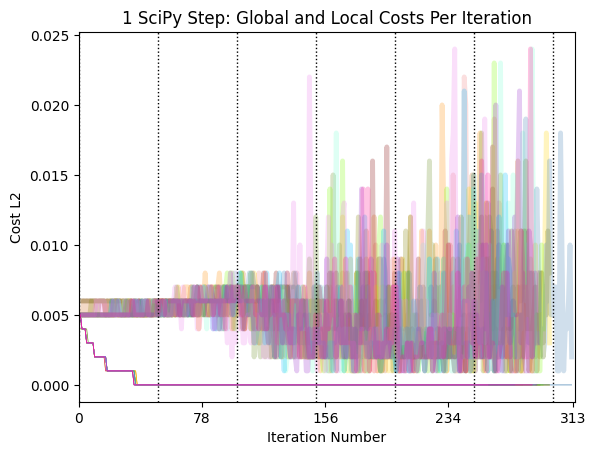

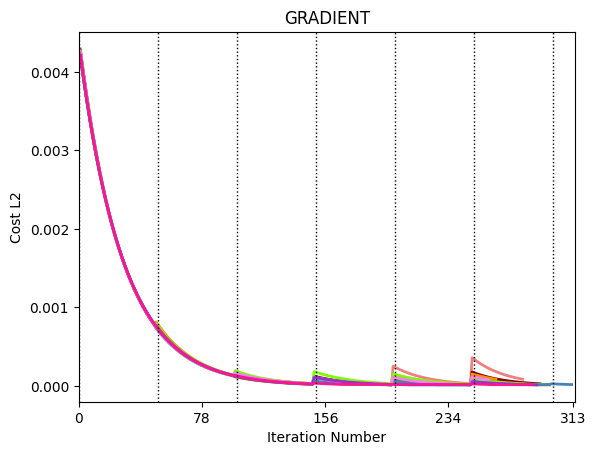

In [31]:
user_c0_1ScipyStep = [Client3(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model_1scipystep = Server3(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
ceplotting(user_c0_1ScipyStep, 'local', dim_reduc_factor=1, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
ceplotting(user_c0_1ScipyStep, 'local', plot_gradient=True, dim_reduc_factor=1, local_error=False, global_error=False, custom_title='GRADIENT')